# Data Science at Scale - Capstone Project

This project was the Capstone Project for the Data Science at Scale specialization offered by the University of Washington on Coursera. The project description is below 

"The project asks you to predict building abandonment (“blight”) based on a number of public datasets, including criminal incidents, permit violations, and more. This project grew out of a roundtable discussion with Socrata and city analytics leaders in Detroit, Kansas City, New Orleans, Boston, and more --- these cities shared a common interest in being proactive about identifying buildings at risk for abandonment and taking steps to prevent the harms that arise as a result. We conducted an initial analysis to check the feasibility of the project, but it remains largely an unsolved problem. Your solutions will have a chance to be deployed in practice and impact city policy."

There were four supplied data files, each are described below.

detroit-blight-violations.csv : Each record is a blight violation incident

detroit-demolition-permits.tsv: Each record represents a permit for a demolition

detroit-311.csv: Each record represents a 311 call, typically a complaint

detroit-crime.csv: Each record represents a criminial incident 
    
The goal of this project is to predict which buildings are blighted or not. The training data for blighted buildings will be obtained from locations with at least one permit incident marked 'Dismantle' (or in some cases 'DISM') in the detroit-demolition-permits.tsv file and non-blighted buildings can be obtained from those that do not appear in this file.

## Loading data and packages

To begin, we load the packages we will end up using as well as the data. The data here was obtained from the Coursera website, but updated information can be obtained from the Detorit governement page which can be found [here](http://data.detroitmi.gov)

In [1]:
#Import the various functions and modules
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import re
import random
from geopy.geocoders import Nominatim

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# For replicability, we will fix a number of random seeds
# For the random module, we can do so right away
random.seed(42)

In [2]:
# Here we load all the data into Pandas dataframe objects
blight_violations_df = pd.read_csv('detroit-blight-violations.csv',encoding='ISO-8859-1',na_values=np.nan)
detroit311_df = pd.read_csv('detroit-311.csv',encoding='ISO-8859-1',na_values=np.nan)
crimes_df = pd.read_csv('detroit-crime.csv',na_values=np.nan)
demolition_df = pd.read_csv('detroit-demolition-permits.tsv', sep='\t',na_values=np.nan)

C:\Users\Ian\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Ian\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Dividing up the city into blocks

We need a way to partition the city based on the latitude and longitude. We can start with very simple and basic idea: grid based on latitude and longitude. This is not perfect, as the city is not on a square grid (see e.g. [map](https://data.detroitmi.gov/Government/City-of-Detroit-Boundary/vqqa-wgrj)). 

Additionally, these square plots may not be the ideal boundries for blight, which may be better represented by city blocks bounded by streerts. Another, coarser possibility would be to use tax or census blocks, which might even allow that data to be added to the model. Further still, we could consider using more colloquial neighborhood designations or zip codes. We could also consider using specific lat/lon to address conversions, but build a buffer around each to indicate the spatial extent. Though in that case we would need to worry about overlap or lack of coverage.

For now, it is better to start simple for a model and iterate later if needed. From the map above, we can roughly estimate the most northern point to be at 42.450 latitude, the most southern part to be at 42.255 latitude, the most western part to be at -83.288 lonitude and the most easter part to be at -82.910 longitude. This box will include many locations not in Detroit, including a large portion of the city of Windsor, but we will try to avoid these in our training. We can then divide this into squares blocks of *latlonStep* size. We have chosen *latlonStep*=0.0001, as is seen in the hyperparameter section. This is backed up by the definition of [decimal degree](https://en.wikipedia.org/wiki/Decimal_degrees), where 0.0001 is usually seen as the size of individual streets/land parcels. Though one is free to change this below.

Below we will define a function that converts a specific latitude/longitude into a box in the grid. This box will be then used to collect the various sites together later.

In [3]:
# Size of the gridID square for training
latlonStep = 0.0001
# We can include our obtained points here
northpoint = 42.450
southpoint = 42.255
westpoint = -83.288
eastpoint = -82.910

# First we calculate the number of grid lines for the lat and lon
# This is based on our rough estimate of the shape, plus the step size of the grid
# latStep and lonStep are defined in the hyperparameters section
latstepNum = int(round((northpoint-southpoint)/latlonStep))
lonstepNum = int(round((eastpoint-westpoint)/latlonStep))

# Now we define a function that will convert a lat/long pair into the gridID
def latlongGrid(latitude, longitude):
    latID = round((northpoint-latitude),4)/latlonStep
    lonID = round((longitude-westpoint),4)/latlonStep
    if 0<=latID and latID<=latstepNum and 0<=lonID and lonID <=lonstepNum:
        gridID = str(int(latID))+'-'+str(int(lonID))
    else:
        gridID = np.nan
    return gridID

# We may also like to have the convertion from gridID to the range of lat/lon
def gridIDBoundries(gridID):
    latID, lonID = [int(x) for x in gridID.split('-')]
    lat = northpoint-(latID+1/2)*latlonStep
    lon = westpoint+(lonID+1/2)*latlonStep
    return (lat, lon)

## Data cleaning

Obviously the data given needs to be cleaned up. Some of the data is missing or malformed, these need to be corrected or removed. Furthermore, the various tables do not have compatible schema, so we will need to find a way to combine the various data entries to fit together. Finally, we will then need to pick and choose what information we can extract from the data into features that can be used in our machine learning models.

In [4]:
# The latitude/longitude is in the address field of a few dataframes
# This regex search will extract the address, if it can find it
def get_lat_long(record, index):
    try:
        lat  = float(re.search(r'.*\((.*), (.*)\)', record).group(1))
        long = float(re.search(r'.*\((.*), (.*)\)', record).group(2))
        return (lat,long)[index]
    except:
        return np.nan

# Simple funciton to convert dollar amount as a string into a dollar amount
def dollar_to_float(record):
    if np.isnan(record):
        return 0.0
    else:
        return float(record[1:])

In [5]:
# Apply the lat/long extraction map
blight_violations_df['ViolationLat'] = blight_violations_df['ViolationAddress'].apply(lambda x: get_lat_long(x,0))
blight_violations_df['ViolationLong'] = blight_violations_df['ViolationAddress'].apply(lambda x: get_lat_long(x,1))
blight_violations_df['MailingLat'] = blight_violations_df['MailingAddress'].apply(lambda x: get_lat_long(x,0))
blight_violations_df['MailingLong'] = blight_violations_df['MailingAddress'].apply(lambda x: get_lat_long(x,1))
demolition_df['SiteLat'] = demolition_df['site_location'].apply(lambda x: get_lat_long(x,0))
demolition_df['SiteLong'] = demolition_df['site_location'].apply(lambda x: get_lat_long(x,1))
demolition_df['OwnerLat'] = demolition_df['owner_location'].apply(lambda x: get_lat_long(x,0))
demolition_df['OwnerLong'] = demolition_df['owner_location'].apply(lambda x: get_lat_long(x,1))

In [6]:
# For now, we will remove entries with lat/lon outside our defined city limits
# We may wish to come back to these address later to see if they can be corrected
blight_violations_df = blight_violations_df[(blight_violations_df['ViolationLat']>southpoint)&(blight_violations_df['ViolationLat']<northpoint)&(blight_violations_df['ViolationLong']<eastpoint)&(westpoint<blight_violations_df['ViolationLong'])]
crimes_df = crimes_df[(crimes_df['LAT']>southpoint) & (crimes_df['LAT']<northpoint) &(crimes_df['LON']<eastpoint) &(westpoint<crimes_df['LON'])]
demolition_df = demolition_df[(demolition_df['SiteLat']<northpoint)&(demolition_df['SiteLat']>southpoint)&(demolition_df['SiteLong']>westpoint)&(demolition_df['SiteLong']<eastpoint)]
detroit311_df = detroit311_df[(detroit311_df['lat']>southpoint)&(detroit311_df['lat']<northpoint)&(detroit311_df['lng']<eastpoint)&(westpoint<detroit311_df['lng'])]

In [7]:
# We now include the gridID for the various indicidents
blight_violations_df['gridID']=blight_violations_df[['ViolationLat','ViolationLong']].apply(lambda x: latlongGrid(x['ViolationLat'], x['ViolationLong']), axis=1)
crimes_df['gridID']=crimes_df[['LAT','LON']].apply(lambda x: latlongGrid(x['LAT'], x['LON']), axis=1)
demolition_df['gridID']=demolition_df[['SiteLat','SiteLong']].apply(lambda x: latlongGrid(x['SiteLat'], x['SiteLong']), axis=1)
detroit311_df['gridID']=detroit311_df[['lat','lng']].apply(lambda x: latlongGrid(x['lat'], x['lng']), axis=1)

In [8]:
# There are number of entries with no fine amount or judgement amount
# We will exclude these from our analysis
NoFineEntries = blight_violations_df[blight_violations_df['FineAmt'].apply(lambda x: pd.isnull(x))].index
blight_violations_df = blight_violations_df.drop(NoFineEntries)
# Then we will convert the string dollar amounts to floats.
blight_violations_df['FineAmt'] = blight_violations_df['FineAmt'].apply(lambda x: float(x[1:]))

In [9]:
# We can now remove some of the fields that are unlikely to be helpful
blight_violations_data = (blight_violations_df.drop(['ViolName',
       'ViolationStreetNumber', 'ViolationStreetName', 'MailingStreetNumber',
       'MailingStreetName', 'MailingCity', 'MailingState', 'MailingZipCode',
       'NonUsAddressCode', 'Country', 'TicketIssuedTime', 'CourtTime',
       'ViolDescription', 'Disposition', 'AdminFee', 'LateFee', 'StateFee',
       'CleanUpCost', 'JudgmentAmt', 'Void', 'ViolationCategory', 
       'ViolationAddress', 'MailingAddress'],axis=1)
                            )
detroit311_data = (detroit311_df.drop(['city','issue_description', 'ticket_closed_date_time', 
        'acknowledged_at', 'ticket_created_date_time', 
        'ticket_last_updated_date_time', 'address',
        'location', 'image'],axis=1)
                   )
crimes_data = (crimes_df.drop(['CASEID', 'INCINO', 'OFFENSEDESCRIPTION',
        'STATEOFFENSEFILECLASS', 'HOUR', 'SCA', 'PRECINCT',
        'COUNCIL', 'NEIGHBORHOOD', 'CENSUSTRACT', 'ADDRESS',
        'LOCATION'],axis=1)
               )

## Feature Engineering

Our goal is to predict whether a plot of land in detroit will contain blight. Blight here is defined to be when a building is condemned and requires demolition. We have a list of demolitions in the demolition_df dataframe. Our goal will be to get a bunch of positive examples, labeled by their gridID
and other gridIDs not in this dataframe will be negative examples. We could find these from gridIDs in the other dataframes that are not within the demolition dataframe. 

Note this means we have an imbalenced class scenario, which we will have to handle when building our model. 

This also means we cannot get any features out of the demolition dataframe, as these would give away immediately which were demolished and which were not (plus we wish to predict if a non-demolished building will eventually be demolished, so any knowledge about a demolition would not be available beforehand).

In [10]:
# Start with getting a count of the demolition permits
demolition_count = (demolition_df.drop(['PERMIT_ISSUED', 
       'SITE_ADDRESS', 'BETWEEN1', 'PARCEL_NO', 'LOT_NUMBER', 'SUBDIVISION',
       'CASE_TYPE', 'CASE_DESCRIPTION', 'ESTIMATED_COST',
       'PARCEL_CLUSTER_SECTOR', 'STORIES', 'PARCEL_FLOOR_AREA',
       'PARCEL_GROUND_AREA', 'PRC_AKA_ADDRESS', 'BLD_PERMIT_TYPE',
       'PERMIT_DESCRIPTION', 'BLD_PERMIT_DESC', 'BLD_TYPE_USE', 'RESIDENTIAL',
       'DESCRIPTION', 'BLD_TYPE_CONST_COD', 'BLD_ZONING_DIST', 'BLD_USE_GROUP',
       'BLD_BASEMENT', 'FEE_TYPE', 'CSM_CASENO', 'CSF_CREATED_BY', 'SEQ_NO',
       'PCF_AMT_PD', 'PCF_AMT_DUE', 'PCF_UPDATED', 'OWNER_LAST_NAME',
       'OWNER_FIRST_NAME', 'OWNER_ADDRESS1', 'OWNER_ADDRESS2', 'OWNER_CITY',
       'OWNER_STATE', 'OWNER_ZIP', 'CONTRACTOR_LAST_NAME',
       'CONTRACTOR_FIRST_NAME', 'CONTRACTOR_ADDRESS1', 'CONTRACTOR_ADDRESS2',
       'CONTRACTOR_CITY', 'CONTRACTOR_STATE', 'CONTRACTOR_ZIP',
       'CONDITION_FOR_APPROVAL', 'site_location', 'owner_location',
       'contractor_location', 'geom', 'SiteLat', 'SiteLong',],axis=1)
                    .groupby(['gridID'])
                    .count()
                    .rename({'PERMIT_NO':'target'},axis=1)['target']
                   )
# If the gridID has at least one demolition, we call it blighted.
# So these counts are all swtiched to just '1', which will indicate blight
demolition_occurance = demolition_count.apply(lambda x: 1 if x > 0 else 0)

In [11]:
# Note that the fraction of blighted gridIDs to all possible ones is quite small!
demolitionFraction = len(demolition_occurance)/len([(i,j) for i in range(latstepNum) for j in range(lonstepNum)])
print("Fracion of gridIDs with demolitions (i.e. blight): "+str(demolitionFraction))

Fracion of gridIDs with demolitions (i.e. blight): 0.0006474019807353141


<IPython.core.display.Javascript object>


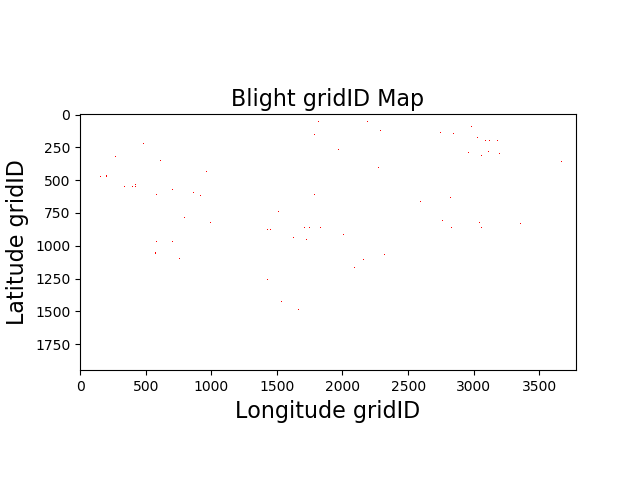

In [12]:
# If one wants to visiualize just how isolated these are, one can do a graph
# Begin by creating a full list of sites and the target
full_map_list = [[1 if str(i)+'-'+str(j) in demolition_occurance.index else 0 for j in range(lonstepNum)] for i in range(latstepNum)]
# Now choose a colour scheme, here using white for no blight, red for blight 
cmap = colors.ListedColormap(['white', 'red'])
bounds=[-0.1, 0.5, 1.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
# Plot this out with matplotlib
plt.figure()
plt.imshow(full_map_list,cmap = cmap,norm=norm)
plt.xlabel('Longitude gridID', fontsize=16)
plt.ylabel('Latitude gridID', fontsize=16)
plt.title('Blight gridID Map', fontsize=16)
plt.show()

In [13]:
# Initial a list of features that we will concat later
# We of course, add in the target to start
feature_list = [demolition_occurance]

In [14]:
# Here we will count the various different crimes each gridID
# Begin by initializing the list
crime_count_list = []
# To keep the num. of features reasonable, we will only keep issues with a number above a set threshold
crimeCategoryThreshold = 50
crimes = crimes_data.groupby(['CATEGORY']).count()[crimes_data.groupby(['CATEGORY']).count()['ROWNUM']>crimeCategoryThreshold].index
# Go through each crime and count for each the gridID
# Append it to the list
for crime in crimes:
    crime_count_list.append(crimes_data[crimes_data['CATEGORY'] == crime].groupby(['gridID']).count().rename({'ROWNUM':crime+'-count'},axis=1)[crime+'-count'])

# We break the crimes into aggregate categories
# This is done by hand, so may be possible to improve
# Currently not doing this
#violent_crimes = ['AGGRAVATED ASSAULT', 'ASSAULT','HOMICIDE', 'KIDNAPING','ROBBERY']
#property_crimes = ['ARSON','BURGLARY','DAMAGE TO PROPERTY','OTHER BURGLARY','LARCENY','STOLEN PROPERTY','STOLEN VEHICLE','WEAPONS OFFENSES','DANGEROUS DRUGS', 'LIQUOR']
#interpersonal_crimes = ['OBSTRUCTING JUDICIARY','OBSTRUCTING THE POLICE','BRIBERY','ESCAPE','EXTORTION','OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE','FORGERY', 'FRAUD','FAMILY OFFENSE', 'RUNAWAY']
#public_crimes = ['ENVIRONMENT', 'PUBLIC PEACE', 'VAGRANCY (OTHER)','HEALTH-SAFETY','TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED','TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS','SOLICITATION']
# With the crimes broken down, we can create a translation dictionary
#crimeCategoryDictionary = {}
#for crime in crimes_data['CATEGORY'].unique():
#    if crime in violent_crimes:
#        crimeCategoryDictionary[crime] = 'violent'
#    elif crime in property_crimes:
#        crimeCategoryDictionary[crime] = 'property'
#    elif crime in interpersonal_crimes:
#        crimeCategoryDictionary[crime] = 'interpersonal'
#    elif crime in public_crimes:
#        crimeCategoryDictionary[crime] = 'public'
#    else:
#        crimeCategoryDictionary[crime] = 'other'
# Now use the dictionary to put the tickets into the categories
#crimes_data['crimeAggregateCategory'] = crimes_data['CATEGORY'].apply(lambda x: crimeCategoryDictionary[x])
# We can now count the number of tickets in the categories 
#for crime in ['violent', 'property','interpersonal', 'public']:
#    crime_count_list.append(crimes_data[crimes_data['crimeAggregateCategory'] == crime].groupby(['gridID']).count().rename({'ROWNUM':crime+'-count'},axis=1)[crime+'-count'])

# Create the full crime count dataframe
crimes_count=pd.concat(crime_count_list, axis=1, join='outer', sort=False).fillna(value=0)
# Append this dataframe to the feature list
feature_list.append(crimes_count)

In [15]:
# Here we will count the various different 311 tickets each gridID
# Begin by initializing the list
d311_count_list = []
# To keep the num. of features reasonable, we will only keep issues with a number above a set threshold
d311IssueThreshold = 100
issues = detroit311_data.groupby(['issue_type']).count()[detroit311_data.groupby(['issue_type']).count()['ticket_id']>d311IssueThreshold].index
# Go through each issue and count for each the gridID
# Append it to the list
for issue in issues:
    d311_count_list.append(detroit311_data[detroit311_data['issue_type'] == issue].groupby(['gridID']).count().rename({'ticket_id':issue+'-count'},axis=1)[issue+'-count'])

# In addition, the proportion of resolved tickets might be important
# This may not be very usefull however, given the low number of tickets/gridID
# To do this, look at ticket_status possibilities. 'Closed' and 'Archived' will counted as resolved.
detroit311_data['resolved_status'] = detroit311_data['ticket_status'].apply(lambda x: 1 if x == 'Closed' or x=='Archived' else 0)
resolvedfraction_series = detroit311_data[['gridID','resolved_status']].groupby(['gridID']).sum().div(detroit311_data.groupby(['gridID']).count().rename({'ticket_id':'total-count'},axis=1)['total-count'],axis=0)
d311_count_list.append(resolvedfraction_series.rename({'resolved_status':'resolved-fraction'},axis=1))

# Create the full 311 count dataframe
d311_count=pd.concat(d311_count_list, axis=1, join='outer', sort=False).fillna(value=0)
# Append this dataframe to the feature list
feature_list.append(d311_count)

In [16]:
# Here we will count the various different blight tickets each gridID
# Begin by initializing the list
blight_count_list = []
# To keep the num. of features reasonable, we will first group the ViolationCode (265 unique violations codes!)
# To do this, group the unique codes into a dictionary
violationCodeDictionary = {}
for i in blight_violations_data['ViolationCode'].unique():
    if i[:3] == '22-':
        violationCodeDictionary[i] = '22-Violation'
    elif i[:2] == '9-':
        violationCodeDictionary[i] = '9-Violation'
    elif i[:3] == '61-':
        violationCodeDictionary[i] = '61-Violation'
    elif i[:2] == '9/':
        violationCodeDictionary[i] = '9/Violation'
# Apply this dictionary to the column to make a new one
blight_violations_data['ViolationGroupCode'] = blight_violations_data['ViolationCode'].apply(lambda x: violationCodeDictionary[x])
# Now apply the threshold to these codes
blightviolationThreshold = 100
violations = blight_violations_data.groupby(['ViolationGroupCode']).count()[blight_violations_data.groupby(['ViolationGroupCode']).count()['TicketID']>blightviolationThreshold].index
# Go through each issue and count for each the gridID
# Append it to the list
for violation in violations:
    blight_count_list.append(blight_violations_data[blight_violations_data['ViolationGroupCode'] == violation].groupby(['gridID']).count().rename({'TicketID':violation+'-count'},axis=1)[violation+'-count'])

# We may also want to consider the average ticket fine
blight_count_list.append(blight_violations_data[['gridID','FineAmt']].groupby(['gridID']).sum().rename({'FineAmt':'fine-avg'},axis=1).div(blight_violations_data.groupby(['gridID']).count()['TicketID'],axis=0))

# Finally, we may also wish to include the fraction of tickets that are paid in each category
# Here we define 'PAID IN FULL' and 'PARTIAL PAYMENT MADE' as paid otherwise unpaid
blight_violations_data['payment-binary']=blight_violations_data['PaymentStatus'].apply(lambda x: 1 if x == 'PAID IN FULL' or x=='PARTIAL PAYMENT MADE' else 0)
blight_count_list.append(blight_violations_data[['gridID','payment-binary']].groupby(['gridID']).sum().rename({'payment-binary':'paymentFraction'},axis=1).div(blight_violations_data.groupby(['gridID']).count()['TicketID'],axis=0))

# We could do the fraction of paid tickets for each violation group
#for violation in violations:
#    blight_count_list.append(blight_violations_data[blight_violations_data['ViolationGroupCode'] == violation][['gridID','payment-binary']].groupby(['gridID']).sum().rename({'payment-binary':violation+'-paymentFraction'},axis=1).div(blight_violations_data[blight_violations_data['ViolationGroupCode'] == violation].groupby(['gridID']).count()['TicketID'],axis=0))

# Create the full blight ticket count dataframe
blight_count=pd.concat(blight_count_list, axis=1, join='outer', sort=False).fillna(value=0)
# Append this dataframe to the feature list
feature_list.append(blight_count)

In [17]:
# We can then merge all the feature Dataframes, using outer join to get some negative examples
training_data_df = pd.concat(feature_list, axis=1, join='outer', sort=False)

# We would also like to add in some gridIDs that don't appear in the DataFrames
# We will add in extraExamples examples but one may wish to change that
# Note we have to be careful to not duplicate the gridIDs already present, but also generate randomly
extraExamples = 10000
# Begin by taking note of taken IDs
taken_gridIDs = training_data_df.index.to_list()
generated_examples_ids = []
# Keep generating examples at random, making sure to only keep new ones
while len(generated_examples_ids) < extraExamples:
    generated_id = str(random.randint(1,latstepNum+1))+'-'+str(random.randint(1,lonstepNum+1))
    if generated_id not in taken_gridIDs:
        generated_examples_ids.append(generated_id)
        taken_gridIDs.append(generated_id)
# Create an emtpy row
empty_row = [np.nan for i in range(0,len(training_data_df.columns))]
# Generate a DataFrame with the gridIDs with the empty rows
generated_df = pd.DataFrame.from_dict({iD:empty_row for iD in generated_examples_ids}, orient='index',  columns=training_data_df.columns)
# Add these examples to the training DataFrame
training_data_df = training_data_df.append(generated_df)

# We can also add the midpoints of the gridIDs
training_data_df['lat'] = training_data_df.index.map(lambda x: gridIDBoundries(x)[0])
training_data_df['lon'] = training_data_df.index.map(lambda x: gridIDBoundries(x)[1])

# Now have to deal with the NaN values
# We can start with the target. If it didn't appear in the demolition_df,
# we will claim that it is not blighted.
target_fillna = {'target':0}
# If there is no criminal incidences for a specific grid, than they wouldn't be in the crimes_count
# This is also true for the 311 incidences and the blight tickets
# So we should fill these with zeros.
crime_fillna = {crime:0 for crime in crimes_count.columns}
d311_fillna = {issue:0 for issue in d311_count.columns if issue != 'resolved-fraction'}
blightTicket_fillna = {violation:0 for violation in blight_count.columns if violation != 'fine-avg' and violation != 'paymentFraction'}
# For the remaining columns, these are dependant on having some ticket/issue
# e.g. fine-avg is the average of blight ticket fines
# But if there is no blight ticket, what should we fill this NaN with?
# We will pick -1, as a indication that these values simply do not apply
remaining_fillna = {'resolved-fraction':-1, 'fine-avg':-1, 'paymentFraction':-1}
# Now we apply these rules to the training data
training_data_df = (training_data_df.fillna(value=target_fillna)
                                    .fillna(value=crime_fillna)
                                    .fillna(value=d311_fillna)
                                    .fillna(value=blightTicket_fillna)
                                    .fillna(value=remaining_fillna)
                   )

In [18]:
# We can take a look at the final training data
training_data_df.head()

,target,AGGRAVATED ASSAULT-count,ARSON-count,ASSAULT-count,BRIBERY-count,BURGLARY-count,DAMAGE TO PROPERTY-count,DANGEROUS DRUGS-count,ENVIRONMENT-count,ESCAPE-count,...,Water Main Break-count,resolved-fraction,22-Violation-count,61-Violation-count,9-Violation-count,9/Violation-count,fine-avg,paymentFraction,lat,lon
10-3241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,1.0,0.0,50.0,0.00,42.44895,-82.96385
10-3275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.00,42.44895,-82.96045
100-2821,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,4.0,0.0,100.0,0.25,42.43995,-83.00585
100-2843,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,4.0,0.0,4.0,0.0,737.5,0.00,42.43995,-83.00365
100-2867,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,1.0,0.0,4.0,0.0,240.0,0.20,42.43995,-83.00125


In [19]:
# A quick check of the fraction of blight here gives
# We can see that the ratio is still off, so this will have to be handled
blight_num = len(training_data_df[training_data_df['target']==1])
blight_frac = blight_num/len(training_data_df)
print('Fraction of blighted sites over all sites: '+str(blight_frac))

Fraction of blighted sites over all sites: 0.0240985759014241


## Model training and evaluation

With our training data and features sorted out, we can now turn to training and evaluating a model. We will go with a simple random forest model, the prediction which is given by a majority vote from a set of decision trees. Random forest has a good fit here, given most of our features are simple discrete values but we do have a few continuous features as well. 

We will split our data and balance our training set by random oversampling. We will train on this balanced trainging set but test the model on an imbalanced one. We will evaluate this using accuracy, precision-recall curve, and F1 score, with the final two being the important measures.

In [20]:
# Split data into features and target
# Split data file into training and testing sets
X = training_data_df.drop(['target'], axis=1)
y = training_data_df['target']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=42)

# We may also want to scale the data,
# So we fit on the training and use the same scaling on the test
sScaler = StandardScaler()
X_train = sScaler.fit_transform(X_train_raw)
X_test = sScaler.transform(X_test_raw)

# We may want to balance the training sets
# We first undersample, randomly, on the scaled data
X_resu, y_resu = RandomUnderSampler(sampling_strategy=1).fit_resample(X_train, y_train.values.ravel())
# We may also wish to use unscaled data, undersampled
X_resu_raw, y_resu_raw = RandomUnderSampler(sampling_strategy=1).fit_resample(X_train_raw, y_train.values.ravel())
# Next we oversample.
X_reso, y_reso = RandomOverSampler(sampling_strategy=1).fit_resample(X_train, y_train.values.ravel())
# And again, oversample but without the scaling
X_reso_raw, y_reso_raw = RandomOverSampler(sampling_strategy=1).fit_resample(X_train_raw, y_train.values.ravel())
# Finally, we can use the SMOTE to generate synthetic samples
X_SMOTE_raw, y_SMOTE_raw = SMOTE().fit_sample(X_train, y_train)

In [21]:
# In order to understand the accuracy of the models, we will consider the baseline using the Zero Rule model
# The acccuracy is given by
accuracyZeroRule = len(y_test[y_test==0])/len(y_test)
print("Zero Rule accuracy: "+str(accuracyZeroRule))
# For precision recall curves, we will use the Random classifier
# The curve then is given by the horizontal line at
blight_frac_test = len(y_test[y_test==1])/len(y_test)
print("Random classifier precision-recall: "+str(blight_frac_test))

Zero Rule accuracy: 0.9758610241389759
Random classifier precision-recall: 0.024138975861024137


In [22]:
# Note have tried a logistic regressions, but only got 
#Accuracy on the training set: 0.7601527307344734
#Accuracy on the test set: 0.6214523785476215
# Looking at a Random Forest Classifier
rfModel = RandomForestClassifier(n_estimators=100,  random_state=42).fit(X_reso_raw, y_reso_raw)

# Find the accuracy on the training and test data
print("Accuracy on the training set: "+str(rfModel.score(X_reso_raw,y_reso_raw)))
print("Accuracy on the test set: "+str(rfModel.score(X_test_raw,y_test)))

Accuracy on the training set: 1.0
Accuracy on the test set: 0.972952227047773


In [23]:
# We can take a look at the importance of the features in descending order
rf_importance = pd.DataFrame(rfModel.feature_importances_.reshape(len(X.columns),1),index=X.columns , columns=['Importance'])
rf_importance.sort_values(by = 'Importance', ascending=False)

,Importance
lon,0.240120
lat,0.229546
fine-avg,0.075867
TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS-count,0.058073
9-Violation-count,0.043863
paymentFraction,0.040592
ASSAULT-count,0.036515
LARCENY-count,0.033504
resolved-fraction,0.031191
DAMAGE TO PROPERTY-count,0.024699


<IPython.core.display.Javascript object>


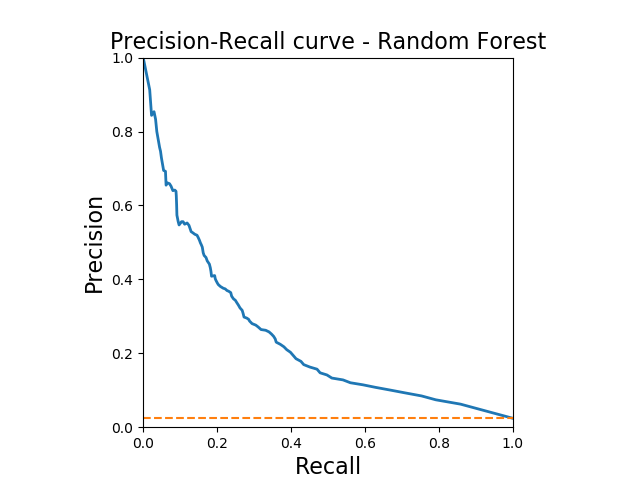

In [24]:
# Consider precision recall curve for alternative evaluation
# ROC improper because of imbalanced classes
# Obtain data from the classifier
y_probs_rf = rfModel.predict_proba(X_test_raw)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf[:,1])
prc_auc_rf = auc(recall, precision)

# Ploting the precision-recall curve
plt.figure()
plt.xlim([0, 1.00])
plt.ylim([0, 1.00])
plt.plot(recall, precision, lw=2)
plt.plot([0, 1], [blight_frac_test, blight_frac_test], linestyle='--')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall curve - Random Forest', fontsize=16)
plt.gca().set_aspect('equal')
plt.show()

# This curve is not great, but does performs better than the baseline

In [25]:
# We can also take a look at the F1 score of the model
# This gives a better pictrue of the model's performace in imbalanced scenarios
rf_F1Score = f1_score(y_test, rfModel.predict(X_test_raw))
print("Zero rule F1 Score: "+str(2*blight_frac_test/(1+blight_frac_test)))
print("Random Forest F1 Score: "+str(rf_F1Score))
# This shows that although this classifier's performance in accuracy seems 
# no better than baseline, it does perform better.

Zero rule F1 Score: 0.04714003944773175
Random Forest F1 Score: 0.2663013698630137


## Model refinement

The above model is one of many possible models. Below, there will be some code  could be used to fine tune the model, by exploring aspects of the hyperparameter space, different methods of addressing the class imbalance, and by studying the results of the model above. 

This section can be skipped, as we would like to just use the best model found here above. So this section will largely be commented out. However, if one wishes to try other refinements, or use a different training set and want to retune the parameters, this section could be helpful.

In [26]:
# Number of trees in random forest
#n_estimators = [100, 500, 1000]
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto', 5, 10, 15]
# Maximum number of levels in tree
max_depth = [None, 10, 25, 50]
#max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 10, 20]
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid of hyperparameters
parameter_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

In [27]:
# Now we use GridSearachCV to run through this grid
#rfModel = GridSearchCV(estimator =  RandomForestClassifier(),
#                       param_grid = parameter_grid,
#                       cv = 5   
#                       )
# Fit the grid search model
#rfModel.fit(X_reso_raw, y_reso_raw)

# Find the accuracy on the training and test data
#print("Accuracy on the training set: "+str(rfModel.best_score_))
#y_pred = rfModel.predict(X_test_raw)
#print("Accuracy on the test set: "+str(accuracy_score(y_test,y_pred)))

In [28]:
# We may want to find parameters for the model with the highest accuracy
#rfModel.best_params_

In [29]:
# We may also be interested in how the various imbalance corrections might preform
# Can compare to non-rebalanced one
#training_sets = {'unbalanced':(X_train_raw, y_train), 'resu':(X_resu_raw, y_resu_raw), 'reso':(X_reso_raw, y_reso_raw), 'SMOTE':(X_SMOTE_raw, y_SMOTE_raw)}
#training_results = {}
#for name, trainSet in training_sets.items():
#    rfModel = RandomForestClassifier(n_estimators=100).fit(trainSet[0], trainSet[1])
#    train_accuracy = rfModel.score(trainSet[0], trainSet[1])
#    test_accuracy = rfModel.score(X_test_raw,y_test)
#    training_results[name] = (train_accuracy,test_accuracy)

# We can then view the results
#training_results

In [30]:
# Now we want to which ones of the validation set was mislabeled
# Start by comparing the test labels with the predicitons
#test_labels_df = y_test.reset_index().drop(['index'],axis=1)
#predictions_df = pd.DataFrame(rfModel.predict(X_test_raw),columns=['target'])
#match_df = (test_labels_df==predictions_df).rename({'target':'correct prediction'},axis=1)
#comparison_df = pd.concat([y_test.reset_index()['index'], match_df,test_labels_df],axis=1)

# Extract the confusion matrix, for a quick overview of the errors
#true_positive = comparison_df[(comparison_df['correct prediction']==True) & (comparison_df['target']==1)]
#true_negative = comparison_df[(comparison_df['correct prediction']==True) & (comparison_df['target']==0)]
#false_negative = comparison_df[(comparison_df['correct prediction']==False) & (comparison_df['target']==1)]
#false_positive = comparison_df[(comparison_df['correct prediction']==False) & (comparison_df['target']==0)]

# Now we can print the accuracy and confusion matrix
#confusion_matrix = pd.DataFrame([['TN: '+str(len(true_negative)),'FN: '+str(len(false_negative))],['FP: '+str(len(false_positive)),'TP: '+str(len(true_positive))]],columns = ['No Blight','Blight'], index = ['Pred. No Blight','Pred. Blight'])
#print('Accuracy: '+str((len(true_positive)+len(true_negative))/float(len(test_labels_df)))) 
#confusion_matrix

In [31]:
# We may wish to take a closer look at the examples in each of the categories
#true_positive_examples = X_test_raw.loc[true_positive['index'].to_list()]
#true_negative_examples = X_test_raw.loc[true_negative['index'].to_list()]
#false_negative_examples = X_test_raw.loc[false_negative['index'].to_list()]
#false_positive_examples = X_test_raw.loc[false_positive['index'].to_list()]

# Depending on what errors we would want to fix, we could focus on whatever

## Application

With a trained model, it would be useful to design a pipeline that would take in an address and spit out a prediction of blight or not, given the data currently in the dataframes. By this, we mean the data frames *blight_violations_data*, *crimes_data*, and *detroit311_data* which have been already preprocessed in the Data Cleaning and Feature Engineering sections.

To do this, we will take in an address, find the lat/lon, build the features by looking for nearby incidences in the dataframes, run it through the model, and finally output the prediction.

Note that the geocoder we will use, Nominatim, won't recognize all addresses. One could switch this out for a non-open source geocoder API if one wished to improve results.

In [32]:
# First, define a function that will take a single address string and find the lat/lon
# This will also check if it is within our city boundries
# To accomplish this, we can use the geopy library.
def addressToLatLon(address):
    geolocator = Nominatim(user_agent="blight_prediction_app")
    try:
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        if lat > northpoint or lat < southpoint or lon > eastpoint or lon < westpoint:
            print("This location is not within the city of Detroit.")
            print("Please ensure the address is correct.")
            return None
        else:
            return (lat, lon)
    except:
        print("There was an error searching for this address.")
        print("Please ensure the address format is correct.")
        return None

# Next, define a function that will query the dataframes
# Note we will look for any indicidents that are within a latlonStep of the given lat/lon
# This is done in a square, as it was to generate the training data
def incidentSearch(lat, lon):
    # Get boundries of square
    latNorth = lat + 0.5 * latlonStep
    latSouth = lat - 0.5 * latlonStep
    lonWest = lon - 0.5 * latlonStep
    lonEast = lon + 0.5 * latlonStep
    # Get all examples within square
    blight_violations_example = blight_violations_data[(blight_violations_data['ViolationLat']>=latSouth)&(blight_violations_data['ViolationLat']<=latNorth)&(blight_violations_data['ViolationLong']<=lonEast)&(lonWest<=blight_violations_data['ViolationLong'])]
    crimes_example = crimes_data[(crimes_data['LAT']>=latSouth) & (crimes_data['LAT']<=latNorth) &(crimes_data['LON']<=lonEast) &(lonWest<=crimes_data['LON'])]
    detroit311_example = detroit311_data[(detroit311_data['lat']>=latSouth)&(detroit311_data['lat']<=latNorth)&(detroit311_data['lng']<=lonEast)&(lonWest<=detroit311_data['lng'])]
    
    # Now we extract the features from this data
    # Initialize an empty list
    feature_list_example = []
    
    # Go through each crime, count the number, and convert dictionary into DataFrame
    crimes_count_example_dict = {crime+'-count':[len(crimes_example[crimes_example['CATEGORY'] == crime])] for crime in crimes}
    crimes_count_example=pd.DataFrame.from_dict(crimes_count_example_dict)
    feature_list_example.append(crimes_count_example)
    
    # Now we analyze the 311 data
    # Begin by initializing the list
    d311_count_example_list= []
    # Go through and do the count for different issues
    d311_count_example_dict = {issue+'-count':[len(detroit311_example[detroit311_example['issue_type'] == issue])] for issue in issues}
    d311_count_example_list.append(pd.DataFrame.from_dict(d311_count_example_dict))
    # Compute the fraction of resolved ticket
    # First check that there are tickets, otherwise set to -1
    if len(detroit311_example) != 0:
        resolvedfraction = {'resolved-fraction':[detroit311_example['resolved_status'].mean()]}
    else:
        resolvedfraction = {'resolved-fraction':[-1]}
    d311_count_example_list.append(pd.DataFrame.from_dict(resolvedfraction))
    # Create the full 311 count dataframe
    d311_count_example=pd.concat(d311_count_example_list, axis=1, join='outer', sort=False)
    # Append this dataframe to the feature list
    feature_list_example.append(d311_count_example)
    
    # Finally look at the blight violations
    # Begin by initializing the list
    blight_count_example_list = []
    # Count the violation group tickets
    blight_count_example_dict = {violation+'-count':[len(blight_violations_example[blight_violations_example['ViolationGroupCode'] == violation])] for violation in violations}
    blight_count_example_list.append(pd.DataFrame.from_dict(blight_count_example_dict))
    # Also compute the average fine, being careful to set -1 for no tickets
    if len(blight_violations_example) != 0:
        fineAvg = {'fine-avg':[blight_violations_example['FineAmt'].mean()]}
    else:
        fineAvg = {'fine-avg':[-1]}
    blight_count_example_list.append(pd.DataFrame.from_dict(fineAvg))
    # Finally, include the fraction of paid tickets
    if len(blight_violations_example) != 0:
        payFrac = {'paymentFraction':[blight_violations_example['payment-binary'].mean()]}
    else:
        payFrac = {'paymentFraction':[-1]}
    blight_count_example_list.append(pd.DataFrame.from_dict(payFrac))
    # Create the full blight ticket count dataframe
    blight_count_example=pd.concat(blight_count_example_list, axis=1, join='outer', sort=False).fillna(value=0)
    # Append this dataframe to the feature list
    feature_list_example.append(blight_count_example)
    
    # Finally, combine these into the final feature vector
    example_data_df = pd.concat(feature_list_example, axis=1, join='outer', sort=False)
    example_data_df['lat'] = lat
    example_data_df['lon'] = lon
    
    return example_data_df.astype(float)

# Finally, define a function that will run all functions above
def blightPredict(address):
    if addressToLatLon(address) is not None:
        lat, lon = addressToLatLon(address)
        prediction = rfModel.predict(incidentSearch(lat, lon))[0]
        if prediction == 1:
            print("Model predicts "+str(prediction)+", blight")
        else:
            print("Model predicts "+str(prediction)+", no blight")
    return None

We can now test a few of these functions. This is to make sure the that lat/lon can be extracted from the addresses and that the search does get tickets correctly.

In [33]:
# Bad address
addressToLatLon('Hello')

This location is not within the city of Detroit.
Please ensure the address is correct.


In [34]:
# Address of Detroit city hall
addressToLatLon('2 Woodward Ave, Detroit, MI 48226, USA')

(42.3292211506024, -83.0453113373494)

In [35]:
# City hall feature vector, which is empty
incidentSearch(42.3292211506024, -83.0453113373494)

,AGGRAVATED ASSAULT-count,ARSON-count,ASSAULT-count,BRIBERY-count,BURGLARY-count,DAMAGE TO PROPERTY-count,DANGEROUS DRUGS-count,ENVIRONMENT-count,ESCAPE-count,EXTORTION-count,...,Water Main Break-count,resolved-fraction,22-Violation-count,61-Violation-count,9-Violation-count,9/Violation-count,fine-avg,paymentFraction,lat,lon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,42.329221,-83.045311


In [36]:
# Feature vector of example with blight violations
incidentSearch(42.363182,-83.091677)

,AGGRAVATED ASSAULT-count,ARSON-count,ASSAULT-count,BRIBERY-count,BURGLARY-count,DAMAGE TO PROPERTY-count,DANGEROUS DRUGS-count,ENVIRONMENT-count,ESCAPE-count,EXTORTION-count,...,Water Main Break-count,resolved-fraction,22-Violation-count,61-Violation-count,9-Violation-count,9/Violation-count,fine-avg,paymentFraction,lat,lon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,10.0,0.0,787.5,0.333333,42.363182,-83.091677


We can also test that full function. We can see that we can input an address and get a prediction out. Below are a few examples of the model getting it right, and others not.

In [37]:
# Shouldn't be blighted, this is city hall
blightPredict('2 Woodward Ave, Detroit, MI 48226, USA')

Model predicts 0.0, no blight


In [38]:
# Should be blighted, is in the demolition dataframe
blightPredict('4331 Barham, Detroit, MI')

Model predicts 0.0, no blight


In [39]:
# Should be blighted, is in the demolition dataframe
blightPredict('5315 Berkshire, Detroit, MI')

Model predicts 1.0, blight
